### Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import statsmodels.api as sms
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

In [5]:
df_airline = pd.read_csv('airline-passengers(1).csv')
df_airline.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df_airline.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [7]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
df_airline['Month'] = pd.to_datetime(df_airline['Month'])

In [9]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [10]:
df_airline.set_index('Month', inplace=True)

In [11]:
df_airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


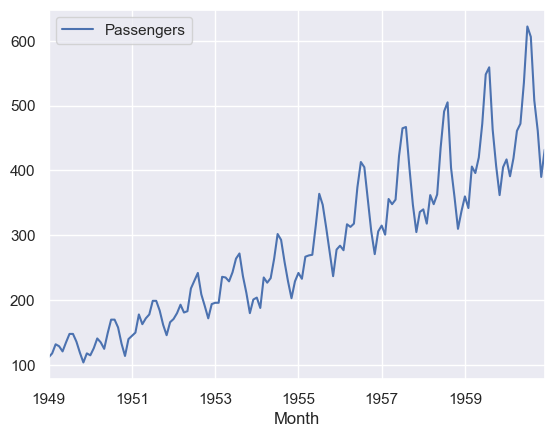

In [12]:
df_airline.plot()
plt.show()
# Seasonal and Trend
#if seasonal data , it is not stationary
# ADFulller test

In [13]:
sts.adfuller(df_airline.Passengers) # our data is not stationary since p-value=0.992 > 0.05 

(0.8153688792060597,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

### Differencing

In [14]:
# Use technique of differencing
df_airline['Passengers_First_Difference'] = df_airline['Passengers'] -df_airline['Passengers'].shift(1)

In [15]:
#df_airline['Passengers_First_Difference'].head(2)

In [16]:
sts.adfuller(df_airline['Passengers_First_Difference'].dropna()) # p-valu=0.054 > 0.05 Thus the data is not stationary

(-2.829266824169992,
 0.0542132902838265,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854085)

In [17]:
#df_airline['returns'] = df_airline.Passengers.pct_change(1)*100

In [18]:
#sts.adfuller(df_airline['returns'].dropna())

In [19]:
# Take second differencing
df_airline['Passengers_Second_Difference'] = df_airline['Passengers_First_Difference']- df_airline['Passengers_First_Difference'].shift(1)

In [20]:
sts.adfuller(df_airline['Passengers_Second_Difference'].dropna())
# p-value is almost zero, so data is stationary now

(-16.384231542468527,
 2.732891850014085e-29,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.60204172756)

In [21]:
# For seasonal data we used 12 month difference
df_airline['Passengers_12_Difference'] = df_airline['Passengers']-df_airline['Passengers'].shift(12) # doing difference for entire year

In [22]:
# check the stationarity of df_airline['Passengers_12_Difference']
sts.adfuller(df_airline['Passengers_12_Difference'].dropna())
# p-value=0.01 <0.05 so data is stationary

(-3.3830207264924805,
 0.011551493085514982,
 1,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 919.527129208137)

In [23]:
df_airline.head()

,Passengers,Passengers_First_Difference,Passengers_Second_Difference,Passengers_12_Difference
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN


### ACF & PACF plots

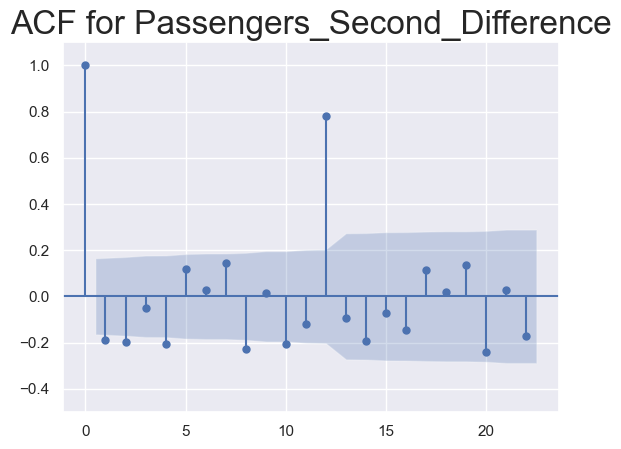

In [24]:
sgt.plot_acf(df_airline['Passengers_Second_Difference'].dropna())
plt.title('ACF for Passengers_Second_Difference', size=24)
plt.ylim(-0.5,1.1)
plt.show()
# q=12

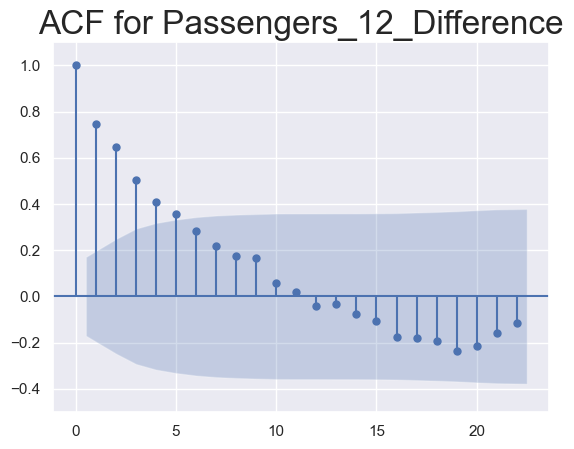

In [25]:
sgt.plot_acf(df_airline['Passengers_12_Difference'].dropna())
plt.title('ACF for Passengers_12_Difference', size=24)
plt.ylim(-0.5,1.1)
plt.show()
# q is q=5, after 5, there is no correlation

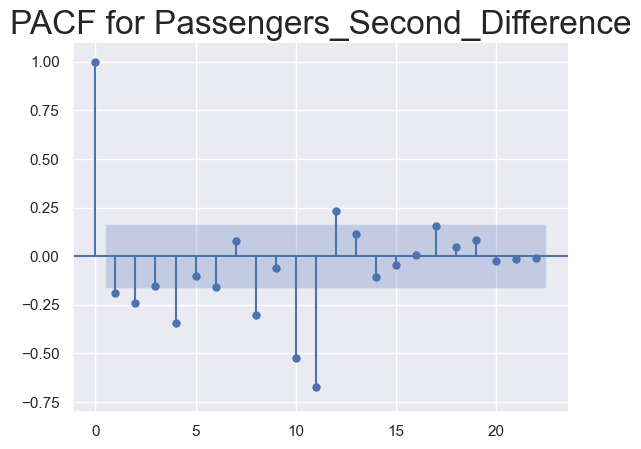

In [26]:
sgt.plot_pacf(df_airline['Passengers_Second_Difference'].dropna())
plt.title('PACF for Passengers_Second_Difference', size=24)
plt.ylim(-0.8,1.1)
plt.show()
# p=14

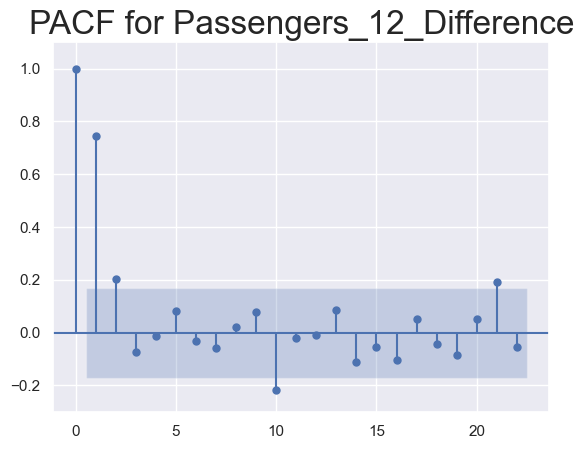

In [27]:
sgt.plot_pacf(df_airline['Passengers_12_Difference'].dropna())
plt.title('PACF for Passengers_12_Difference', size=24)
plt.ylim(-0.3,1.1)
plt.show()

### Train & Test dataset (80:20)

In [28]:
df_airline = df_airline.dropna()

In [29]:
df_airline.describe()
size = int(len(df_airline)*0.8)
size

105

In [30]:
size = int(len(df_airline)*0.8)
df_train, df_test = df_airline.iloc[:size], df_airline.iloc[size:]

In [31]:
df_train.head()

,Passengers,Passengers_First_Difference,Passengers_Second_Difference,Passengers_12_Difference
Month,,,,
1950-01-01,115,-3.0,-17.0,3.0
1950-02-01,126,11.0,14.0,8.0
1950-03-01,141,15.0,4.0,9.0
1950-04-01,135,-6.0,-21.0,6.0
1950-05-01,125,-10.0,-4.0,4.0


In [32]:
df_test.head()

,Passengers,Passengers_First_Difference,Passengers_Second_Difference,Passengers_12_Difference
Month,,,,
1958-10-01,359,-45.0,56.0,12.0
1958-11-01,310,-49.0,-4.0,5.0
1958-12-01,337,27.0,76.0,1.0
1959-01-01,360,23.0,-4.0,20.0
1959-02-01,342,-18.0,-41.0,24.0


### Create ARIMA Model

In [33]:
model_arima = ARIMA(df_train['Passengers'], order=(10,12,5))
rsults_arima = model_arima.fit()
rsults_arima.summary()

C:\Users\Hamid.Azizi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamid.Azizi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamid.Azizi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamid.Azizi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Hamid.Azizi\AppData\Local\anaconda3\Lib\si

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  105
Model:               ARIMA(10, 12, 5)   Log Likelihood                   0.000
Date:                Tue, 23 Apr 2024   AIC                             32.000
Time:                        11:07:21   BIC                             72.522
Sample:                    01-01-1950   HQIC                            48.361
                         - 09-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -7.4198         -0        inf      0.000      -7.420      -7.420
ar.L2        -23.5469         -0        inf      0.000     -23.547     -23.547
ar.L3        -39.9668         -0        inf      0.000     -39.967     -39.967
ar.L4        -33.9125   3.85e-07  -8.81e+07      0.000     -33.913     -33.913
ar.L5          0.1713         -0       -inf      0.000       0.171       0.171
ar.L6         34.0917         -0       -inf      0.000      34.092      34.092
ar.L7         39.8781         -0       -inf      0.000      39.878      39.878
ar.L8         23.3828         -0       -inf      0.000      23.383      23.383
ar.L9          7.3372         -0       -inf      0.000       7.337       7.337
ar.L10         0.9849         -0       -inf      0.000       0.985       0.985
ma.L1         -1.1830         -0        inf      0.000      -1.183      -1.183
ma.L2         -0.9850         -0        inf      0.000      -0.985      -0.985
ma.L3          0.9673         -0       -inf      0.000       0.967       0.967
ma.L4          1.1902         -0       -inf      0.000       1.190       1.190
ma.L5         -0.9895         -0        inf      0.000      -0.990      -0.990
sigma2      1.057e+04         -0       -inf      0.000    1.06e+04    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [34]:
# All the coefficients are significant

### Prediction

In [35]:
df_test.head()

,Passengers,Passengers_First_Difference,Passengers_Second_Difference,Passengers_12_Difference
Month,,,,
1958-10-01,359,-45.0,56.0,12.0
1958-11-01,310,-49.0,-4.0,5.0
1958-12-01,337,27.0,76.0,1.0
1959-01-01,360,23.0,-4.0,20.0
1959-02-01,342,-18.0,-41.0,24.0


In [36]:
pred_start_date = df_test.index[0]
pred_end_date = df_test.index[-1]
print(pred_start_date)
print(pred_end_date)

1958-10-01 00:00:00
1960-12-01 00:00:00


In [37]:
prediction = rsults_arima.predict(start = pred_start_date, end = pred_end_date)
#residuals = df_test['Passengers']-prediction 

In [38]:
#df_test['Passengers']

In [39]:
#prediction

In [40]:
#residuals

In [41]:
#rsults_arima.resid.plot(kind='kde')

In [42]:
df_test['Predicted_ARIMA'] = prediction

C:\Users\Hamid.Azizi\AppData\Local\Temp\1\ipykernel_14500\798091373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predicted_ARIMA'] = prediction


<Axes: xlabel='Month'>

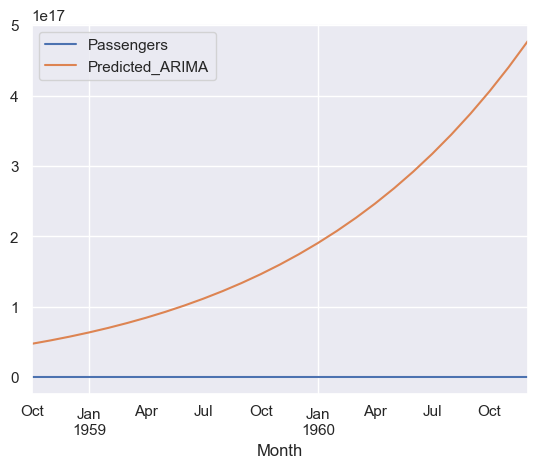

In [43]:
df_test[['Passengers', 'Predicted_ARIMA']].plot()

In [44]:
mse_ARIMA = mean_squared_error(df_test['Passengers'], df_test['Predicted_ARIMA'])
mse_ARIMA

5.431419072483256e+34

In [ ]:
# ARIMA is not a good model for seasonal data forecasting

### Create ETS Model_additive

In [128]:
df_test.head()

,Passengers,Passengers_First_Difference,Passengers_Second_Difference,Passengers_12_Difference,Predicted_ARIMA
Month,,,,,
1958-10-01,359,-45.0,56.0,12.0,4.746997e+16
1958-11-01,310,-49.0,-4.0,5.0,5.237402e+16
1958-12-01,337,27.0,76.0,1.0,5.773434e+16
1959-01-01,360,23.0,-4.0,20.0,6.358880e+16
1959-02-01,342,-18.0,-41.0,24.0,6.997800e+16


In [130]:
model_ETS = ExponentialSmoothing(df_train['Passengers'], trend="add", seasonal='add', seasonal_periods=12)
results_ETS = model_ETS.fit()
results_ETS.summary()

C:\Users\Hamid.Azizi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,Passengers,No. Observations:,105
Model:,ExponentialSmoothing,SSE,14909.658
Optimized:,True,AIC,552.359
Trend:,Additive,BIC,594.823
Seasonal:,Additive,AICC,560.313
Seasonal Periods:,12,Date:,"Mon, 18 Mar 2024"
Box-Cox:,False,Time:,12:22:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2269933,alpha,True
smoothing_trend,9.6527e-09,beta,True


In [131]:
predictions_ETS = results_ETS.forecast(steps=len(df_test))

In [132]:
df_test['Predicted_ETS'] = predictions_ETS

C:\Users\Hamid.Azizi\AppData\Local\Temp\1\ipykernel_11920\3118464019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predicted_ETS'] = predictions_ETS


In [133]:
df_test.head()

,Passengers,Passengers_First_Difference,Passengers_Second_Difference,Passengers_12_Difference,Predicted_ARIMA,Predicted_ETS
Month,,,,,,
1958-10-01,359,-45.0,56.0,12.0,4.746997e+16,356.110889
1958-11-01,310,-49.0,-4.0,5.0,5.237402e+16,316.498478
1958-12-01,337,27.0,76.0,1.0,5.773434e+16,350.781991
1959-01-01,360,23.0,-4.0,20.0,6.358880e+16,358.714967
1959-02-01,342,-18.0,-41.0,24.0,6.997800e+16,342.098623


<Axes: xlabel='Month'>

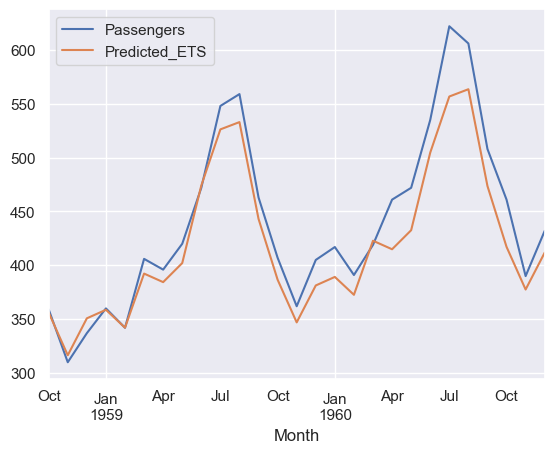

In [134]:
df_test[['Passengers', 'Predicted_ETS']].plot()

In [135]:
mse_ETS_add = mean_squared_error(df_test['Passengers'], df_test['Predicted_ETS'])
mse_ETS_add

706.7939125129695

### Create ETS Model_Multiplicative

In [136]:
model_ETS_mul = ExponentialSmoothing(df_train['Passengers'], trend="mul", seasonal='mul', seasonal_periods=12)
results_ETS_mul = model_ETS_mul.fit()
results_ETS_mul.summary()

C:\Users\Hamid.Azizi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamid.Azizi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Dep. Variable:,Passengers,No. Observations:,105
Model:,ExponentialSmoothing,SSE,7021.620
Optimized:,True,AIC,473.293
Trend:,Multiplicative,BIC,515.756
Seasonal:,Multiplicative,AICC,481.246
Seasonal Periods:,12,Date:,"Mon, 18 Mar 2024"
Box-Cox:,False,Time:,12:23:15
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8126533,alpha,True
smoothing_trend,7.5648e-05,beta,True


In [137]:
df_test['Predicted_ETS_mul'] = results_ETS_mul.forecast(steps=len(df_test))

C:\Users\Hamid.Azizi\AppData\Local\Temp\1\ipykernel_11920\1945439469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predicted_ETS_mul'] = results_ETS_mul.forecast(steps=len(df_test))


In [138]:
df_test.head()

,Passengers,Passengers_First_Difference,Passengers_Second_Difference,Passengers_12_Difference,Predicted_ARIMA,Predicted_ETS,Predicted_ETS_mul
Month,,,,,,,
1958-10-01,359,-45.0,56.0,12.0,4.746997e+16,356.110889,358.589048
1958-11-01,310,-49.0,-4.0,5.0,5.237402e+16,316.498478,315.050294
1958-12-01,337,27.0,76.0,1.0,5.773434e+16,350.781991,356.505842
1959-01-01,360,23.0,-4.0,20.0,6.358880e+16,358.714967,365.008798
1959-02-01,342,-18.0,-41.0,24.0,6.997800e+16,342.098623,353.459808


<Axes: xlabel='Month'>

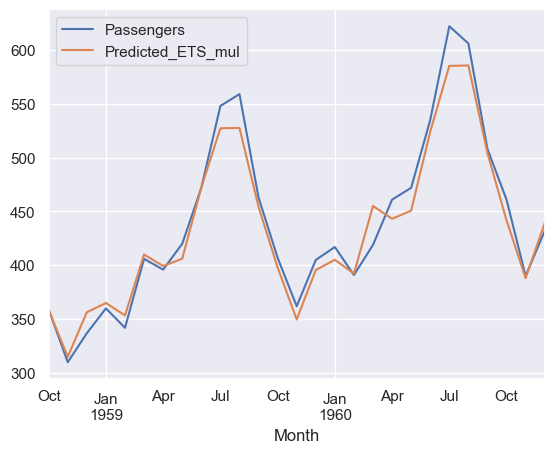

In [139]:
df_test[['Passengers', 'Predicted_ETS_mul']].plot()

### Evaluate Forecast Accuracy_ETS Model_Multiplicatiove

In [140]:
mse_ETS_mul = mean_squared_error(df_test['Passengers'], df_test['Predicted_ETS_mul'])
mse_ETS_mul

264.37363900709454

### Accuracy of ETS_mul model is higher than ETS_add and ARIMA models 
### For seasonal data forecasting, ARIMA is not working. ETS or SARIMA are better options.